https://www.kaggle.com/code/sugghi/training-3rd-place-solution/notebook
ここのソリューションをBybitで実装してみる。

変更点：
    ・　通貨ペアーは取引の多いものを選ぶ（１４まで選ぶと１分足が作れない可能性があるため減らす）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import datetime

import pickle
import gc

from tqdm import tqdm

In [2]:
n_fold = 7
seed0 = 8586

In [3]:
# そのままコピー
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
import rbot

bb_btcusd = rbot.DummyBb()
bb_btcusd.market_type = "BTCUSD"
bb_btcusdt = rbot.DummyBb()
bb_btcusdt.market_type = "BTCUSDT"

bb_ethusd = rbot.DummyBb()
bb_ethusd.market_type = "ETHUSD"
bb_ethusdt = rbot.DummyBb()
bb_ethusdt.market_type = "ETHUSDT"

bb_xrpusdt = rbot.DummyBb()
bb_xrpusdt.market_type = "XRPUSDT"
bb_xrpusd = rbot.DummyBb()
bb_xrpusd.market_type = "XRPUSD"

bb_solusdt = rbot.DummyBb()
bb_solusdt.market_type = "SOLUSDT"


In [5]:
# 注意　１０GB レベルでDiskを消費します。
# 2回目は LOAD_NEWをFalseにするとダンプファイルからロードするので高速です。
LOAD_NEW = True
LOAD_DAYS = 100

if LOAD_NEW:
    bb_btcusd.log_load(LOAD_DAYS)
    bb_btcusd.dump()
    bb_btcusdt.log_load(LOAD_DAYS)
    bb_btcusdt.dump()
    bb_ethusd.log_load(LOAD_DAYS)
    bb_ethusd.dump()
    bb_ethusdt.log_load(LOAD_DAYS)
    bb_ethusdt.dump()
    bb_xrpusd.log_load(LOAD_DAYS)
    bb_xrpusd.dump()
    bb_xrpusdt.log_load(LOAD_DAYS)
    bb_xrpusdt.dump()
    bb_solusdt.log_load(LOAD_DAYS)
    bb_solusdt.dump()
else:
    bb_btcusd.restore()
    bb_btcusdt.restore()
    bb_ethusd.restore()
    bb_ethusdt.restore()
    bb_xrpusd.restore()
    bb_xrpusdt.restore()
    bb_solusdt.restore()


In [6]:
OFFSET_PERIOD = 15

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

# Closeのログリターンを計算する（Closeでいいのかな？）
def make_df(dummy_bb, asset_id):
    df = rbot.array_to_df(dummy_bb.ohlcv(0, 0, 60))
    df['Target'] = log_return(df['close'], OFFSET_PERIOD)
    df['Asset_ID'] = asset_id
    
    return df

In [7]:
df_btcusd = make_df(bb_btcusd, 0)
df_btcusdt = make_df(bb_btcusdt, 1)
df_ethusd = make_df(bb_ethusd, 2)
df_ethusdt = make_df(bb_ethusdt, 3)
df_xrpusd = make_df(bb_xrpusd, 4)
df_xrpusdt = make_df(bb_xrpusdt, 5)
df_solusdt = make_df(bb_solusdt, 6)

df_train = pd.concat([df_btcusd, df_btcusdt, df_ethusd, df_ethusdt, df_xrpusd, df_xrpusdt, df_solusdt])
df_train = reduce_mem_usage(df_train)
df_train

Memory usage of dataframe is 61.43 MB
Memory usage after optimization is: 22.08 MB
Decreased by 64.1%


,open,high,low,close,volume,Target,Asset_ID
timestamp,,,,,,,
2022-03-27 00:00:00+00:00,44544.00000,44544.00000,44544.00000,44544.00000,122635.000000,NaN,0
2022-03-27 00:01:00+00:00,44544.00000,44544.00000,44512.00000,44512.00000,129101.000000,NaN,0
2022-03-27 00:02:00+00:00,44512.00000,44512.00000,44480.00000,44512.00000,407347.000000,NaN,0
2022-03-27 00:03:00+00:00,44512.00000,44512.00000,44512.00000,44512.00000,204417.000000,NaN,0
2022-03-27 00:04:00+00:00,44512.00000,44544.00000,44512.00000,44544.00000,487144.000000,NaN,0
...,...,...,...,...,...,...,...
2022-07-04 23:55:00+00:00,36.84375,36.84375,36.78125,36.78125,1898.699951,0.001904,6
2022-07-04 23:56:00+00:00,36.78125,36.81250,36.78125,36.81250,2975.899902,0.003948,6
2022-07-04 23:57:00+00:00,36.81250,36.84375,36.78125,36.81250,3651.199951,0.005451,6


In [8]:
df_train['timestamp'] = df_train.index.astype('int64')
df_train['Close'] = df_train["close"]
df_train = df_train.reset_index(drop=True)
df_train = reduce_mem_usage(df_train)
df_train


Memory usage of dataframe is 24.00 MB
Memory usage after optimization is: 24.00 MB
Decreased by 0.0%


,open,high,low,close,volume,Target,Asset_ID,timestamp,Close
0,44544.00000,44544.00000,44544.00000,44544.00000,122635.000000,NaN,0,1648339200000000000,44544.00000
1,44544.00000,44544.00000,44512.00000,44512.00000,129101.000000,NaN,0,1648339260000000000,44512.00000
2,44512.00000,44512.00000,44480.00000,44512.00000,407347.000000,NaN,0,1648339320000000000,44512.00000
3,44512.00000,44512.00000,44512.00000,44512.00000,204417.000000,NaN,0,1648339380000000000,44512.00000
4,44512.00000,44544.00000,44512.00000,44544.00000,487144.000000,NaN,0,1648339440000000000,44544.00000
...,...,...,...,...,...,...,...,...,...
1006489,36.84375,36.84375,36.78125,36.78125,1898.699951,0.001904,6,1656978900000000000,36.78125
1006490,36.78125,36.81250,36.78125,36.81250,2975.899902,0.003948,6,1656978960000000000,36.81250
1006491,36.81250,36.84375,36.78125,36.81250,3651.199951,0.005451,6,1656979020000000000,36.81250
1006492,36.81250,36.81250,36.65625,36.65625,3171.600098,0.003006,6,1656979080000000000,36.65625


In [9]:
NUM_OF_ASSETS = 7

train_merged = pd.DataFrame()
train_merged[df_train.columns] = 0
for id in tqdm( range(NUM_OF_ASSETS) ):
    train_merged = train_merged.merge(df_train.loc[df_train["Asset_ID"] == id, ['timestamp', 'Close','Target']].copy(), on="timestamp", how='outer',suffixes=['', "_"+str(id)])
        
train_merged = train_merged.drop(df_train.columns.drop("timestamp"), axis=1)
train_merged = train_merged.sort_values('timestamp', ascending=True)
display(train_merged.head())


100%|██████████| 7/7 [00:00<00:00, 25.28it/s]


,timestamp,Close_0,Target_0,Close_1,Target_1,Close_2,Target_2,Close_3,Target_3,Close_4,Target_4,Close_5,Target_5,Close_6,Target_6
0,1648339200000000000,44544.0,NaN,44480.0,NaN,3146.0,NaN,3144.0,NaN,0.832520,NaN,0.833008,NaN,101.6875,NaN
1,1648339260000000000,44512.0,NaN,44480.0,NaN,3146.0,NaN,3144.0,NaN,0.832520,NaN,0.833008,NaN,101.6875,NaN
2,1648339320000000000,44512.0,NaN,44480.0,NaN,3144.0,NaN,3142.0,NaN,0.832520,NaN,0.832520,NaN,101.6875,NaN
3,1648339380000000000,44512.0,NaN,44480.0,NaN,3144.0,NaN,3142.0,NaN,0.832031,NaN,0.831543,NaN,101.7500,NaN
4,1648339440000000000,44544.0,NaN,44512.0,NaN,3144.0,NaN,3142.0,NaN,0.832031,NaN,0.832520,NaN,101.7500,NaN


In [10]:
for id in range(NUM_OF_ASSETS):
    # print(id, train_merged[f'Close_{id}'].isnull().sum())   # Number of missing before forward fill
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].astype('object').fillna(method='ffill', limit=100)
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].astype('float64')


In [11]:
lags = [60,300,900]

def get_features(df, train=True):   
    if train == True:
        totimestamp = lambda s: np.int32(time.mktime(datetime.datetime.strptime(s, "%d/%m/%Y").timetuple()))
        valid_window = [totimestamp("12/03/2021")]
#         valid_window = [totimestamp("15/08/2021")]  #検証用
        df['train_flg'] = np.where(df['timestamp']>=valid_window[0], 0,1)

        supple_start_window = [totimestamp("22/09/2021")]

        #if use_supple_for_train:
        #    df['train_flg'] = np.where(df['timestamp']>=supple_start_window[0], 1 ,df['train_flg']  )
   
    for id in range(NUM_OF_ASSETS):    
        for lag in lags:
            df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
            df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
    for lag in lags:
        df[f'mean_close/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_close/mean_{lag}_id')], axis=1)
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_return_{lag}_id')] ,    axis=1)
        for id in range(NUM_OF_ASSETS):
            df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )
            df[f'log_return_{lag}-mean_log_returns_{lag}_id{id}']    = np.array( df[f'log_return_{lag}_id{id}'])     - np.array( df[f'mean_log_returns_{lag}'] )

    if train == True:
        for id in range(NUM_OF_ASSETS):
            df = df.drop([f'Close_{id}'], axis=1)
        oldest_use_window = [totimestamp("12/01/2019")]
        df = df[  df['timestamp'] >= oldest_use_window[0]   ]

    return df

In [12]:
feat = get_features(train_merged)
feat

,timestamp,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,train_flg,log_close/mean_60_id0,...,log_close/mean_900-mean_close/mean_900_id2,log_return_900-mean_log_returns_900_id2,log_close/mean_900-mean_close/mean_900_id3,log_return_900-mean_log_returns_900_id3,log_close/mean_900-mean_close/mean_900_id4,log_return_900-mean_log_returns_900_id4,log_close/mean_900-mean_close/mean_900_id5,log_return_900-mean_log_returns_900_id5,log_close/mean_900-mean_close/mean_900_id6,log_return_900-mean_log_returns_900_id6
0,1648339200000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10.704233,...,2.086736,0.105218,2.086100,0.103630,-6.150450,-0.023922,-6.149864,-0.024108,-1.345247,0.134220
1,1648339260000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10.703514,...,2.086838,0.105541,2.086202,0.103953,-6.150347,-0.024371,-6.149761,-0.024556,-1.345144,0.134543
2,1648339320000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10.703514,...,2.086468,0.105580,2.085832,0.103991,-6.150082,-0.024649,-6.150082,-0.025420,-1.344879,0.136163
3,1648339380000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10.703514,...,2.086632,0.105880,2.085995,0.103339,-6.150505,-0.024936,-6.151092,-0.026294,-1.344101,0.137077
4,1648339440000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10.704233,...,2.086259,0.105642,2.085622,0.103101,-6.150878,-0.025173,-6.150291,-0.025358,-1.344474,0.135891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143993,1656978900000000000,-0.002125,-0.001974,-0.000217,-0.000043,0.001525,0.001826,0.001904,0,0.001056,...,0.006866,0.023811,0.006571,0.022777,-0.014834,-0.031662,-0.013496,-0.030974,0.029767,0.042347
143994,1656978960000000000,-0.001731,-0.001630,0.000261,0.000347,0.001831,0.002741,0.003948,0,0.001030,...,0.006939,0.023314,0.006643,0.023231,-0.015444,-0.032903,-0.013365,-0.029929,0.030665,0.042699
143995,1656979020000000000,-0.000692,-0.000494,0.000783,0.000347,0.003048,0.003351,0.005451,0,0.000990,...,0.005862,0.022151,0.005568,0.022069,-0.013363,-0.030194,-0.013515,-0.030223,0.030434,0.042405
143996,1656979080000000000,-0.001362,-0.001385,-0.000653,-0.000435,0.001527,0.000915,0.003006,0,-0.000634,...,0.006503,0.023745,0.006211,0.022711,-0.013898,-0.030789,-0.014047,-0.031587,0.028541,0.040533


In [13]:
# define features for LGBM
not_use_features_train = ['timestamp', 'train_flg']
for id in range(NUM_OF_ASSETS):
    not_use_features_train.append(f'Target_{id}')

features = feat.columns 
features = features.drop(not_use_features_train)
features = list(features)
# display(features)  
len(features)

90

In [14]:
#del train_merged
#del df_train
gc.collect()

72

In [15]:
# define the evaluation metric
def correlation(a, train_data):
    
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# For CV score calculation
def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [16]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
# (used in nyanp's Optiver solution)
def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [17]:
# from: https://www.kaggle.com/code/nrcjea001/lgbm-embargocv-weightedpearson-lagtarget/
def get_time_series_cross_val_splits(data, cv = n_fold, embargo = 3750):
    all_train_timestamps = data['timestamp'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last timestamps, in case the number of timestamps wasn't divisible by cv
    rem = len(all_train_timestamps) - len_split*cv
    if rem>0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the timestamps that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage. Note timestamps are expressed in seconds, so multiply by 60
        embargo_sec = 60*embargo
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

In [18]:
def get_Xy_and_model_for_asset(df_proc, asset_id):
    df_proc = df_proc.loc[  (df_proc[f'Target_{asset_id}'] == df_proc[f'Target_{asset_id}'])  ]
    #if not_use_overlap_to_train:
    #   df_proc = df_proc.loc[  (df_proc['train_flg'] == 1)  ]
    
# EmbargoCV
    train_test_zip = get_time_series_cross_val_splits(df_proc, cv = n_fold, embargo = 3750)
    print("entering time series cross validation loop")
    importances = []
    oof_pred = []
    oof_valid = []
    
    for split, train_test_split in enumerate(train_test_zip):
        gc.collect()
        
        print(f"doing split {split+1} out of {n_fold}")
        train_split, test_split = train_test_split
        train_split_index = df_proc['timestamp'].isin(train_split)
        test_split_index = df_proc['timestamp'].isin(test_split)
    
        train_dataset = lgb.Dataset(df_proc.loc[train_split_index, features],
                                    df_proc.loc[train_split_index, f'Target_{asset_id}'].values, 
                                    feature_name = features, 
                                   )
        val_dataset = lgb.Dataset(df_proc.loc[test_split_index, features], 
                                  df_proc.loc[test_split_index, f'Target_{asset_id}'].values, 
                                  feature_name = features, 
                                 )

        print(f"number of train data: {len(df_proc.loc[train_split_index])}")
        print(f"number of val data:   {len(df_proc.loc[test_split_index])}")

        model = lgb.train(params = params,
                          train_set = train_dataset, 
                          valid_sets=[train_dataset, val_dataset],
                          valid_names=['tr', 'vl'],
                          num_boost_round = 5000,
                          verbose_eval = 100,     
                          feval = correlation,
                         )
        importances.append(model.feature_importance(importance_type='gain'))
        
        file = f'trained_model_id{asset_id}_fold{split}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print(f"Trained model was saved to 'trained_model_id{asset_id}_fold{split}.pkl'")
        print("")
            
        oof_pred += list(  model.predict(df_proc.loc[test_split_index, features])        )
        oof_valid += list(   df_proc.loc[test_split_index, f'Target_{asset_id}'].values    )
    
    
    plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))

    return oof_pred, oof_valid

In [19]:
# Weigthの計算が不明

df_asset_details = pd.DataFrame(data={
    'Asset_ID': [0, 1, 2, 3, 4, 5, 6], 
    'Weight': [1, 1, 1, 1, 1, 1, 1],
    "Asset_Name": ['BTCUSD', 'BTCUSDT', 'ETHUSD', 'ETHUSDT', 'XRPUSD', 'XRPUSDT', "SOLUSDT"],
    })
df_asset_details

,Asset_ID,Weight,Asset_Name
0,0,1,BTCUSD
1,1,1,BTCUSDT
2,2,1,ETHUSD
3,3,1,ETHUSDT
4,4,1,XRPUSD
5,5,1,XRPUSDT
6,6,1,SOLUSDT


In [20]:
params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
#     'metric': 'None',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'verbose': -1,
    'max_bin':600,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 2,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
    }

Training model for BTCUSD           (ID=0 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123414
number of val data:   20569


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00281261	tr's corr: 0.764338	vl's rmse: 0.0016962	vl's corr: 0.766473
[200]	tr's rmse: 0.00267549	tr's corr: 0.784044	vl's rmse: 0.0016495	vl's corr: 0.777232
[300]	tr's rmse: 0.00262937	tr's corr: 0.791277	vl's rmse: 0.00164118	vl's corr: 0.779573
[400]	tr's rmse: 0.00260925	tr's corr: 0.794501	vl's rmse: 0.00163782	vl's corr: 0.780745
Early stopping, best iteration is:
[411]	tr's rmse: 0.00260745	tr's corr: 0.794786	vl's rmse: 0.00163684	vl's corr: 0.781046
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold0.pkl'

doing split 2 out of 7
number of train data: 123414
number of val data:   20569
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00282653	tr's corr: 0.76326	vl's rmse: 0.00157419	vl's corr: 0.784551
[200]	tr's rmse: 0.00268839	tr's corr: 0.783205	vl's rmse: 0.00151081	vl's corr: 0.797983
[300]	tr's rmse: 0.00263681	tr's corr: 0.791358	vl's rmse

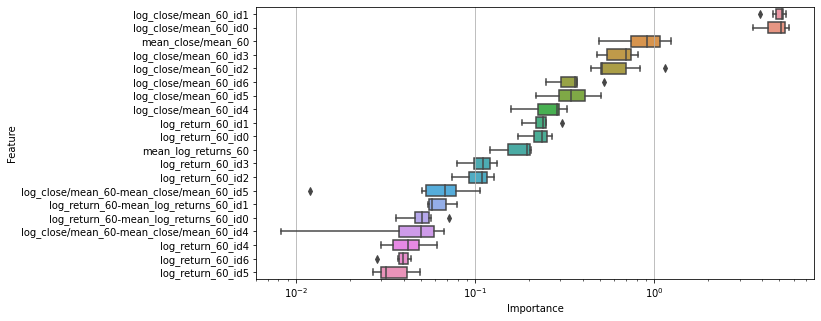

OOF corr score of BTCUSD (ID=0) is 0.78496. (Weight: 1.00000)


Training model for BTCUSDT          (ID=1 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123383
number of val data:   20563


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00282292	tr's corr: 0.755462	vl's rmse: 0.00171534	vl's corr: 0.759035
[200]	tr's rmse: 0.00267677	tr's corr: 0.778088	vl's rmse: 0.00167075	vl's corr: 0.76838
[300]	tr's rmse: 0.00262861	tr's corr: 0.78589	vl's rmse: 0.00165908	vl's corr: 0.771657
Early stopping, best iteration is:
[348]	tr's rmse: 0.00261519	tr's corr: 0.788105	vl's rmse: 0.00165568	vl's corr: 0.772729
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold0.pkl'

doing split 2 out of 7
number of train data: 123383
number of val data:   20563
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00281677	tr's corr: 0.757997	vl's rmse: 0.00158369	vl's corr: 0.78128
[200]	tr's rmse: 0.00268526	tr's corr: 0.777855	vl's rmse: 0.00152636	vl's corr: 0.792863
[300]	tr's rmse: 0.00263907	tr's corr: 0.785309	vl's rmse: 0.00150648	vl's corr: 0.797566
[400]	tr's rmse: 0.00261501	tr's corr: 0.789345	vl's rmse

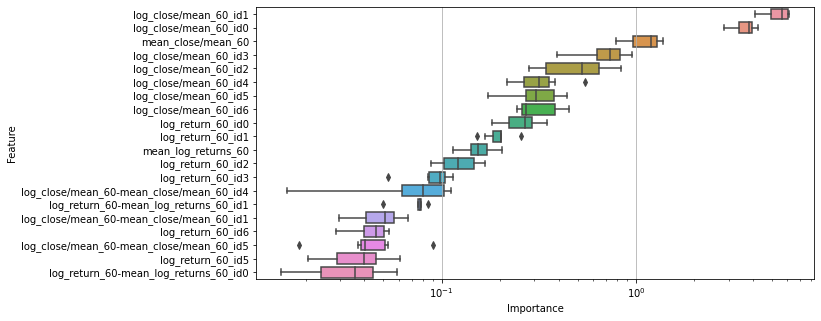

OOF corr score of BTCUSDT (ID=1) is 0.77998. (Weight: 1.00000)


Training model for ETHUSD           (ID=2 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123265
number of val data:   20544


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0037009	tr's corr: 0.767495	vl's rmse: 0.00201965	vl's corr: 0.774729
[200]	tr's rmse: 0.00351594	tr's corr: 0.787803	vl's rmse: 0.00196809	vl's corr: 0.785248
Early stopping, best iteration is:
[227]	tr's rmse: 0.00349129	tr's corr: 0.790709	vl's rmse: 0.00196354	vl's corr: 0.786331
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold0.pkl'

doing split 2 out of 7
number of train data: 123265
number of val data:   20544
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00371315	tr's corr: 0.768953	vl's rmse: 0.00171283	vl's corr: 0.792373
[200]	tr's rmse: 0.00353111	tr's corr: 0.788669	vl's rmse: 0.00165964	vl's corr: 0.802553
[300]	tr's rmse: 0.00346861	tr's corr: 0.796057	vl's rmse: 0.00164655	vl's corr: 0.80529
[400]	tr's rmse: 0.00342949	tr's corr: 0.800765	vl's rmse: 0.00163931	vl's corr: 0.806955
[500]	tr's rmse: 0.0034065	tr's corr: 0.803541	vl's rmse

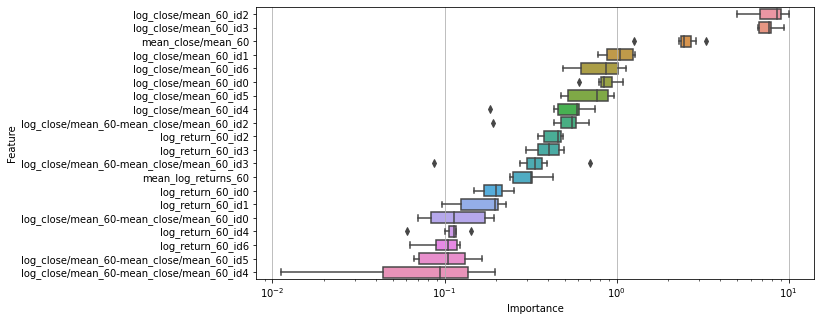

OOF corr score of ETHUSD (ID=2) is 0.78436. (Weight: 1.00000)


Training model for ETHUSDT          (ID=3 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123378
number of val data:   20563


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00366654	tr's corr: 0.767003	vl's rmse: 0.00202808	vl's corr: 0.76912
[200]	tr's rmse: 0.00348889	tr's corr: 0.786687	vl's rmse: 0.00200375	vl's corr: 0.773234
[300]	tr's rmse: 0.00342526	tr's corr: 0.794393	vl's rmse: 0.00198964	vl's corr: 0.777257
Early stopping, best iteration is:
[334]	tr's rmse: 0.00341048	tr's corr: 0.796192	vl's rmse: 0.00198449	vl's corr: 0.778667
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold0.pkl'

doing split 2 out of 7
number of train data: 123378
number of val data:   20563
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00368866	tr's corr: 0.767287	vl's rmse: 0.00172175	vl's corr: 0.79149
[200]	tr's rmse: 0.00350467	tr's corr: 0.78748	vl's rmse: 0.00166846	vl's corr: 0.801305
[300]	tr's rmse: 0.00343827	tr's corr: 0.795393	vl's rmse: 0.00165231	vl's corr: 0.804609
[400]	tr's rmse: 0.00340354	tr's corr: 0.799593	vl's rmse

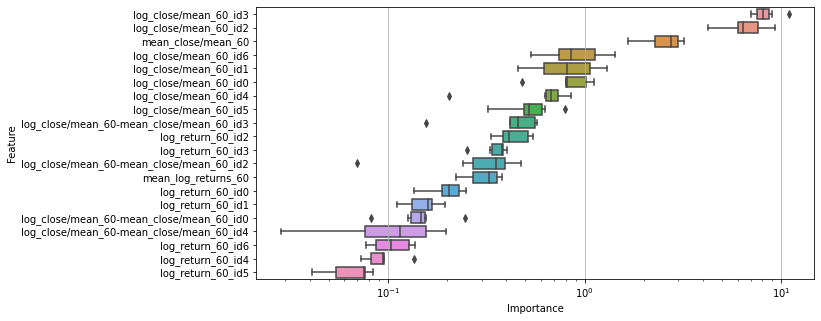

OOF corr score of ETHUSDT (ID=3) is 0.78224. (Weight: 1.00000)


Training model for XRPUSD           (ID=4 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 122989
number of val data:   20498


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00376269	tr's corr: 0.746932	vl's rmse: 0.00238188	vl's corr: 0.745816
[200]	tr's rmse: 0.00355618	tr's corr: 0.772162	vl's rmse: 0.00231906	vl's corr: 0.755468
[300]	tr's rmse: 0.00347993	tr's corr: 0.781885	vl's rmse: 0.00230608	vl's corr: 0.757646
Early stopping, best iteration is:
[300]	tr's rmse: 0.00347993	tr's corr: 0.781885	vl's rmse: 0.00230608	vl's corr: 0.757646
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold0.pkl'

doing split 2 out of 7
number of train data: 122989
number of val data:   20498
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0037883	tr's corr: 0.745197	vl's rmse: 0.00209877	vl's corr: 0.785145
[200]	tr's rmse: 0.00358328	tr's corr: 0.770051	vl's rmse: 0.00201035	vl's corr: 0.799815
[300]	tr's rmse: 0.0035001	tr's corr: 0.780709	vl's rmse: 0.00198082	vl's corr: 0.805298
[400]	tr's rmse: 0.00344781	tr's corr: 0.787725	vl's rms

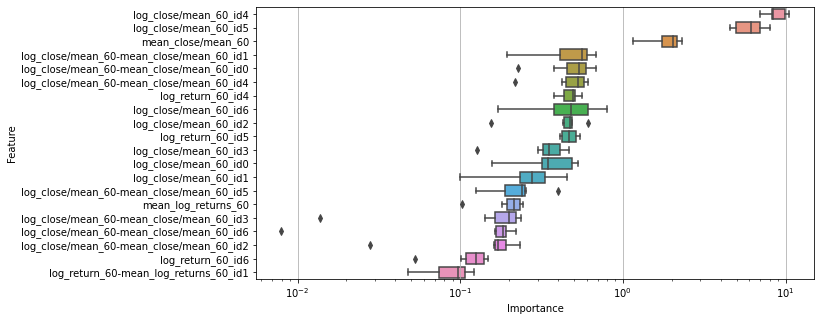

OOF corr score of XRPUSD (ID=4) is 0.75552. (Weight: 1.00000)


Training model for XRPUSDT          (ID=5 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 122841
number of val data:   20473


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0037734	tr's corr: 0.742284	vl's rmse: 0.00243122	vl's corr: 0.743715
[200]	tr's rmse: 0.00357201	tr's corr: 0.767206	vl's rmse: 0.00233738	vl's corr: 0.760684
[300]	tr's rmse: 0.00348857	tr's corr: 0.778368	vl's rmse: 0.00231238	vl's corr: 0.765458
Early stopping, best iteration is:
[312]	tr's rmse: 0.00348251	tr's corr: 0.779175	vl's rmse: 0.0023113	vl's corr: 0.765627
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold0.pkl'

doing split 2 out of 7
number of train data: 122841
number of val data:   20473
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00378481	tr's corr: 0.742708	vl's rmse: 0.00210949	vl's corr: 0.789455
[200]	tr's rmse: 0.00358642	tr's corr: 0.76724	vl's rmse: 0.00202122	vl's corr: 0.803288
[300]	tr's rmse: 0.00350533	tr's corr: 0.778095	vl's rmse: 0.00199456	vl's corr: 0.808294
[400]	tr's rmse: 0.00345814	tr's corr: 0.784295	vl's rmse

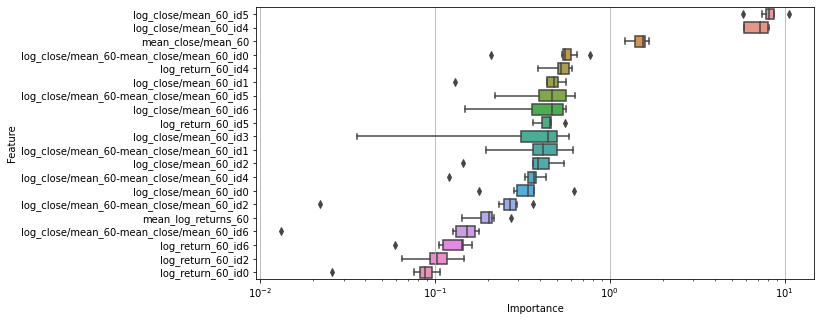

OOF corr score of XRPUSDT (ID=5) is 0.75802. (Weight: 1.00000)


Training model for SOLUSDT          (ID=6 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123351
number of val data:   20558


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00543505	tr's corr: 0.759918	vl's rmse: 0.00381362	vl's corr: 0.782471
[200]	tr's rmse: 0.00512468	tr's corr: 0.78454	vl's rmse: 0.00365581	vl's corr: 0.79672
[300]	tr's rmse: 0.00499863	tr's corr: 0.795316	vl's rmse: 0.00360619	vl's corr: 0.801711
[400]	tr's rmse: 0.00493173	tr's corr: 0.800892	vl's rmse: 0.00358219	vl's corr: 0.804117
[500]	tr's rmse: 0.00487926	tr's corr: 0.805349	vl's rmse: 0.00357151	vl's corr: 0.805156
[600]	tr's rmse: 0.00484092	tr's corr: 0.808621	vl's rmse: 0.00356465	vl's corr: 0.805866
[700]	tr's rmse: 0.004814	tr's corr: 0.810902	vl's rmse: 0.00355948	vl's corr: 0.806391
[800]	tr's rmse: 0.00479412	tr's corr: 0.812602	vl's rmse: 0.00355754	vl's corr: 0.80658
[900]	tr's rmse: 0.00477668	tr's corr: 0.814094	vl's rmse: 0.00355623	vl's corr: 0.8067
[1000]	tr's rmse: 0.00475884	tr's corr: 0.815633	vl's rmse: 0.00355541	vl's corr: 0.806775
Early stopping, best iteration is:
[986]	tr's

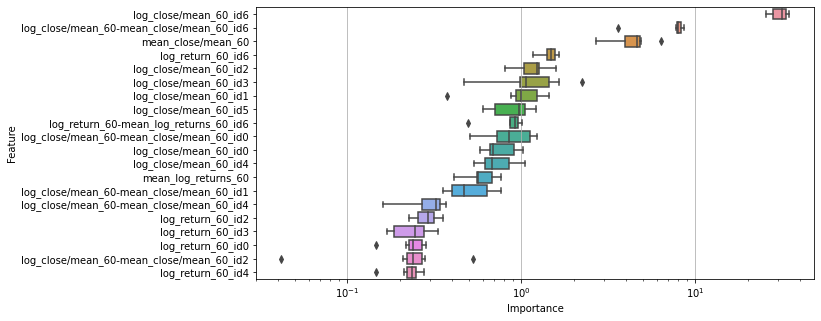

OOF corr score of SOLUSDT (ID=6) is 0.77820. (Weight: 1.00000)




In [21]:
oof = [ [] for id in range(NUM_OF_ASSETS)   ]

all_oof_pred = []
all_oof_valid = []
all_oof_weight = []

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    
    oof_pred, oof_valid = get_Xy_and_model_for_asset(feat, asset_id)
    
    weight_temp = float( df_asset_details.loc[  df_asset_details['Asset_ID'] == asset_id  , 'Weight'   ]  )
    
    all_oof_pred += oof_pred
    all_oof_valid += oof_valid
    all_oof_weight += [weight_temp] * len(oof_pred)
    
    oof[asset_id] = corr_score(     np.array(oof_pred)   ,    np.array(oof_valid)    )
    
    print(f'OOF corr score of {asset_name} (ID={asset_id}) is {oof[asset_id]:.5f}. (Weight: {float(weight_temp):.5f})')
    print('')
    print('')

In [22]:
woof = 0
for id in range(NUM_OF_ASSETS):
    woof += oof[id] * float(  df_asset_details.loc[  df_asset_details['Asset_ID'] == id  , 'Weight'   ] )
woof = woof / df_asset_details['Weight'].sum()

print(f'OOF corr scores are;')
for oof_score in oof:
    print(f'      {oof_score:.5f}')
print(f'  simple average corr score: {np.mean(oof):.5f}.')
print(f'weighted average corr score: {woof:.5f}.')
print(f'')

all_oof_wcorr = wcorr_score(     np.array(all_oof_pred),    np.array(all_oof_valid),  np.array(all_oof_weight)   )
print(f'        weighted corr score: {all_oof_wcorr:.5f}.')

OOF corr scores are;
      0.78496
      0.77998
      0.78436
      0.78224
      0.75552
      0.75802
      0.77820
  simple average corr score: 0.77475.
weighted average corr score: 0.77475.

        weighted corr score: 0.77442.
